In [34]:
# Dependencies
import tweepy
import json
import numpy as np
from tweepy.binder import bind_api
import matplotlib.pyplot as plt

########
# Advanced stuff
########
# I have patched the Tweepy API here, fixing the missing `page=x` parameter in `search()`.
# Just to make a point... :)
########

class FixedAPI(tweepy.API):
    @property
    def search(self):
        """ :reference: https://dev.twitter.com/rest/reference/get/search/tweets
            :allowed_param:'q', 'lang', 'locale', 'since_id', 'geocode',
             'max_id', 'since', 'until', 'result_type', 'count',
              'include_entities', 'from', 'to', 'source'
        """
        return bind_api(
            api=self,
            path='/search/tweets.json',
            payload_type='search_results',
            allowed_param=['q', 'lang', 'locale', 'since_id', 'geocode',
                           'max_id', 'since', 'until', 'result_type',
                           'count', 'include_entities', 'from','page',
                           'to', 'source']
        )

#END PATCH

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
consumer_key = "yourkey"
consumer_secret = "yourkey"
access_token = "yourkey"
access_token_secret = "yourkey"

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
#api = FixedAPI(auth) #<-- this overrides the tweepy's api, fixing the api.search() bug. Just FYI. You dont need to use this unless you;re curious

# Target Search Term
target_terms = ("@SouthwestAir", "@AmericanAir", "@SpiritAirlines",
                "@Virginatlantic", "@Delta", "@AlaskaAir", "@KLM")

# "Real Person" Filters
min_tweets = 5
max_tweets = 10000
max_followers = 2500
max_following = 2500
lang = "en"


# Variable for holding the oldest tweet
oldest_tweet = ""

# Loop through all target users

def is_good_tweet(tweet, min_tweets=5, max_tweets=100000, min_followers=10, max_following=2500, lang="en"):
    
    if (tweet["user"]["followers_count"] < max_followers and
        tweet["user"]["statuses_count"] > min_tweets and
        tweet["user"]["statuses_count"] < max_tweets and
        tweet["user"]["friends_count"] < max_following and
            tweet["user"]["lang"] == lang):
        return True
    else:
        return False

all_sentiments = []  

#loop through all airlines
for target in target_terms:

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    public_tweets = []
    
    #First, get 1500 tweets each
    #UPDATE: We now must use cursors, because of a bug in tweepy
    #        This means we also need to pre-process each tweet 
    #        to convert it to json manually
    for page in tweepy.Cursor(api.search, q=target, count=200).pages():
        
        public_tweets = public_tweets + [t._json for t in page] #manual json conversion
        if len(public_tweets) > 1500:
            break

    # Next, Loop through all tweets
    # 1) skip "bad" ones
    # 2) perform sentiment analysis on "good" ones
    # 3) append all sentiment data to lists for analysis later
    for tweet in public_tweets:

        # Use filters to check if user meets conditions
        if is_good_tweet(tweet):

            # Run Vader Analysis on each tweet
            score = analyzer.polarity_scores(tweet["text"])
            
            compound = score["compound"]
            pos = score["pos"]
            neu = score["neu"]
            neg = score["neg"]

            # Add each value to the appropriate array
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)

    # Store the Average Sentiments
    sentiment = {"User": target,
             "Compound": np.mean(compound_list),
             "Positive": np.mean(positive_list),
             "Neutral": np.mean(neutral_list),
             "Negative": np.mean(negative_list),
             "Tweet Count": len(compound_list)}

    # Print the Sentiments
    print(sentiment)
    all_sentiments.append(sentiment)
    print("")



{'Positive': 0.07147734627831716, 'Tweet Count': 1236, 'Negative': 0.047148867313915856, 'Compound': 0.05677686084142394, 'Neutral': 0.8813729773462783, 'User': '@SouthwestAir'}

{'Positive': 0.10167092924126171, 'Tweet Count': 1173, 'Negative': 0.07201790281329924, 'Compound': 0.07274262574595056, 'Neutral': 0.826308610400682, 'User': '@AmericanAir'}

{'Positive': 0.09845374449339207, 'Tweet Count': 1135, 'Negative': 0.08501938325991189, 'Compound': 0.032400881057268724, 'Neutral': 0.8165242290748899, 'User': '@SpiritAirlines'}

{'Positive': 0.12145051194539247, 'Tweet Count': 1172, 'Negative': 0.045751706484641635, 'Compound': 0.14961740614334473, 'Neutral': 0.8328003412969284, 'User': '@Virginatlantic'}

{'Positive': 0.0968232044198895, 'Tweet Count': 1267, 'Negative': 0.05824388318863456, 'Compound': 0.07582367797947909, 'Neutral': 0.8449384372533544, 'User': '@Delta'}

{'Positive': 0.13310103626943004, 'Tweet Count': 1158, 'Negative': 0.04025302245250432, 'Compound': 0.20609179620

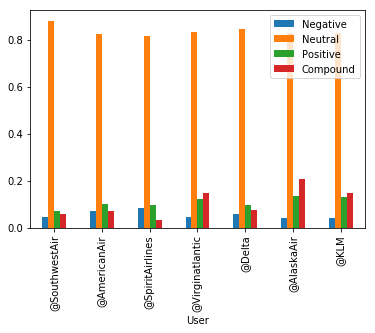

In [35]:
#Will this data tell a different story if we use median instead of mean? 
#I'll leave that to you
import matplotlib.pyplot as plt

df = pd.DataFrame(all_sentiments)
df = df.set_index('User')
df[['Negative','Neutral','Positive','Compound']].plot.bar()
plt.show()